# Delta‑Only Hedging (SPX) — Using OptionMetrics OMunderlying.csv for Spot

This notebook mirrors the delta–vega structure but performs **delta-only hedging**.
- Load option data (`options_dataset.parquet`).
- Load OMunderlying.csv spot levels instead of Yahoo prices.
- Use SPX close prices as the underlying for mark-to-market.
- Daily delta‑hedge using the underlying only (no vega hedge).
- Self‑financing accounting, no transaction costs on spot.
- 21‑trading‑day non‑overlapping windows from 2021‑01‑01 onward.


In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

TRADING_DAYS_PER_MONTH = 21
OPTIONS_PARQUET = "../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../data/OMunderlying.csv"

pd.set_option('display.max_columns', 100)

In [2]:
# === 1) Load OptionMetrics option dataset ===
df = pd.read_parquet(OPTIONS_PARQUET)
df = df[df['ticker'] == 'SPX'].copy()
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])

# strike scaling (1,505,000 → 1,505)
if df['strike_price'].median() > 1e4:
    df['strike_price'] = df['strike_price'] / 1000.0

df['mid'] = (df['best_bid'] + df['best_offer']) / 2.0
df['dte'] = (df['exdate'] - df['date']).dt.days

print("Option rows (raw):", len(df))

Option rows (raw): 36251366


In [3]:
# === 2) Load OptionMetrics OMunderlying.csv as spot ===
spot_df = pd.read_csv(OM_UNDERLYING_CSV)
spot_df['date'] = pd.to_datetime(spot_df['date'])
spot_df = spot_df[spot_df['ticker'] == 'SPX'][['date','close']].rename(columns={'close':'spot'})
spot_df = spot_df.drop_duplicates(subset=['date'], keep='last').sort_values('date')

print("OM spot rows:", len(spot_df))
print("Date range:", spot_df['date'].min().date(), "→", spot_df['date'].max().date())

OM spot rows: 5954
Date range: 2000-01-03 → 2023-08-31


In [4]:
# === 3) Merge & filter ≈1‑month maturity ===
df = df.merge(spot_df, on='date', how='inner')
df['moneyness'] = df['strike_price'] / df['spot']
df_1m = df[(df['dte'] >= 15) & (df['dte'] <= 35)].copy()

# quality filters
df_1m = df_1m.replace([np.inf,-np.inf], np.nan)
df_1m = df_1m.dropna(subset=['mid','delta','vega','best_bid','best_offer'])
df_1m = df_1m[df_1m['best_offer'] >= df_1m['best_bid']]
df_1m['spread'] = (df_1m['best_offer'] - df_1m['best_bid']).clip(lower=0)
df_1m['rel_spread'] = df_1m['spread'] / df_1m['mid']

liq = (
    (df_1m['mid'] > 0.05) &
    (df_1m['rel_spread'] <= 0.35) &
    df_1m['delta'].between(-1.1,1.1) &
    (df_1m['vega'] > 0)
)
df_1m = df_1m[liq].copy()
print("1M rows after cleaning:", len(df_1m))

1M rows after cleaning: 5689084


In [5]:
def choose_strike_for_m0(spot0: float, m0: float, strikes: np.ndarray) -> float:
    target = m0 * spot0
    return float(strikes[np.abs(strikes-target).argmin()])

def pick_one(day_df, strike, cp_flag):
    sub = day_df[(day_df['strike_price']==strike)&(day_df['cp_flag']==cp_flag)].copy()
    if sub.empty: return None
    sub = sub.dropna(subset=['mid','delta','vega'])
    sub = sub[sub['best_offer']>=sub['best_bid']]
    if sub.empty: return None
    sub = sub.sort_values(by=['open_interest','volume'], ascending=[False,False])
    return sub.iloc[0]

def fetch_next_row(next_df, strike, cp_flag):
    nxt = next_df[(next_df['strike_price']==strike)&(next_df['cp_flag']==cp_flag)]
    if nxt.empty: return None
    nxt = nxt.dropna(subset=['mid'])
    nxt = nxt.sort_values(by=['open_interest','volume'], ascending=[False,False])
    return nxt.iloc[0]

In [6]:
# === 4) One‑day step (delta‑only) ===
def one_day_step(df_all, d, d_next, K_straddle, phi_under_prev, use_costs=False):
    day = df_all[df_all['date']==d]; day_next = df_all[df_all['date']==d_next]
    if day.empty or day_next.empty: return None
    rowC = pick_one(day,K_straddle,'C')
    rowP = pick_one(day,K_straddle,'P')
    if (rowC is None) or (rowP is None): return None
    rowC_n = fetch_next_row(day_next,K_straddle,'C')
    rowP_n = fetch_next_row(day_next,K_straddle,'P')
    if (rowC_n is None) or (rowP_n is None): return None

    spot_t, spot_t1 = rowC['spot'], rowC_n['spot']
    psiC, psiP = 1.0, 1.0
    V_t = psiC*rowC['mid'] + psiP*rowP['mid']
    dV_t = psiC*rowC['delta'] + psiP*rowP['delta']
    phi_under = dV_t
    pnl_under = phi_under*(spot_t1-spot_t)
    if use_costs:
        # Assume 2 bps cost per rebalance (institutional estimate)
        cost_under = abs(phi_under - phi_under_prev) * spot_t * 0.0002
    else:
        cost_under = 0.0
    pnl_unhedged = psiC*(rowC_n['mid']-rowC['mid']) + psiP*(rowP_n['mid']-rowP['mid'])
    return dict(date=d, V_t=V_t, phi_under=phi_under,
                pnl_under=pnl_under, pnl_unhedged=pnl_unhedged, cost_under=cost_under)

In [ ]:
# === 5) Run one 21‑day window ===
def get_window_dates(df_all,start_idx):
    dates=np.sort(df_all['date'].unique())
    if start_idx+TRADING_DAYS_PER_MONTH>=len(dates): return None
    return list(dates[start_idx:start_idx+TRADING_DAYS_PER_MONTH+1])

def run_single_window(df_all,start_idx,m0, use_costs=False):
    days=get_window_dates(df_all,start_idx)
    if days is None: return None
    d0=days[0]; day0=df_all[df_all['date']==d0]
    spot0=float(day0['spot'].iloc[0]); strikes=np.sort(day0['strike_price'].unique())
    K_straddle=choose_strike_for_m0(spot0,m0,strikes)
    phi_prev=0.0; recs=[]; V0=None; Pi_t=None
    for t in range(len(days)-1):
        step=one_day_step(df_all,days[t],days[t+1],K_straddle,phi_prev, use_costs=use_costs)
        if step is None: return None
        
        if V0 is None: V0=step['V_t']; Pi_t=V0
        Pi_t1=Pi_t+step['pnl_under'] - step['cost_under'] # self-financing update
        step['Pi_t']=Pi_t; step['Pi_t1']=Pi_t1
        recs.append(step); phi_prev=step['phi_under']; Pi_t=Pi_t1
    last_day, fin_day = days[-2], days[-1]
    dL=df_all[df_all['date']==last_day]; dF=df_all[df_all['date']==fin_day]
    rC=pick_one(dL,K_straddle,'C'); rC_f=fetch_next_row(dF,K_straddle,'C')
    rP=pick_one(dL,K_straddle,'P'); rP_f=fetch_next_row(dF,K_straddle,'P')
    if (rC is None) or (rC_f is None) or (rP is None) or (rP_f is None): return None
    V_T=float(rC_f['mid']+rP_f['mid']); Pi_T=float(recs[-1]['Pi_t1'])
    return dict(summary=dict(start=days[0],end=days[-1],m0=m0,
                             K_straddle=K_straddle,
                             V0=recs[0]['V_t'],
                             V_T=V_T,Pi_T=Pi_T,
                             tracking_error=V_T-Pi_T,
                             pnl_unhedged=V_T-recs[0]['V_t'],
                             pnl_hedged=Pi_T-recs[0]['V_t']),
                timeline=pd.DataFrame(recs))

In [8]:
# === 6) Multi‑window loop ===
def run_experiment(df_all,m0_list,max_windows=52):
    dts=np.sort(df_all['date'].unique())
    starts=list(range(0,len(dts)-TRADING_DAYS_PER_MONTH-1,TRADING_DAYS_PER_MONTH))
    starts=starts[:max_windows]; results=[]
    for m in m0_list:
        for si in starts:
            out=run_single_window(df_all,si,m, use_costs=True)
            if out is not None: results.append(out['summary'])
    return pd.DataFrame(results)

In [9]:
# === 7) Backtest setup ===
start_bt = pd.Timestamp("2021-01-01")
df_bt=df_1m[df_1m['date']>=start_bt].copy().sort_values('date')
m0_list=[0.75,0.8,0.9,1.1,1.2,1.25]
results_delta=run_experiment(df_bt,m0_list,max_windows=52)
results_delta.head(10)
res = results_delta.sort_values('end').reset_index(drop=True).copy()

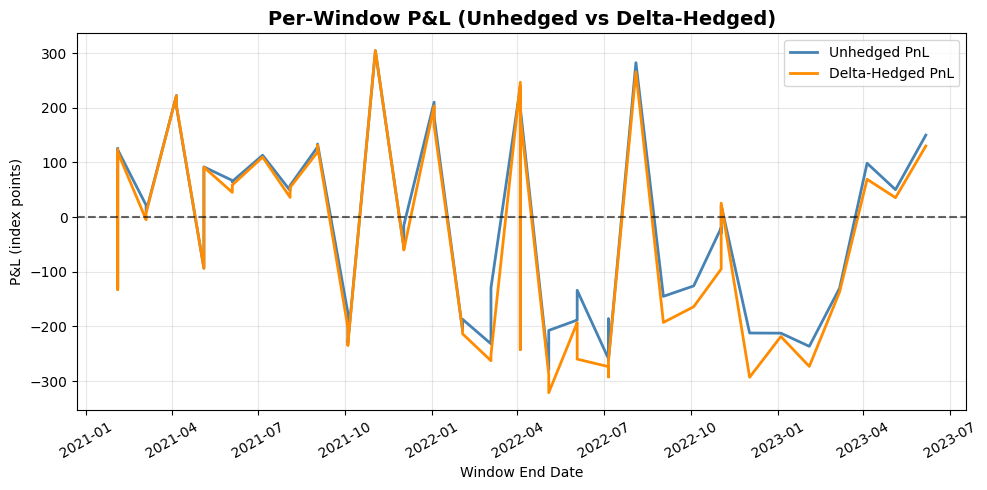

In [10]:
plt.figure(figsize=(10,5))
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL', color='steelblue', linewidth=2)
plt.plot(res['end'], res['pnl_hedged'], label='Delta-Hedged PnL', color='darkorange', linewidth=2)
plt.axhline(0, linestyle='--', color='black', alpha=0.6)
plt.title('Per‑Window P&L (Unhedged vs Delta‑Hedged)', fontsize=14, fontweight='bold')
plt.xlabel('Window End Date')
plt.ylabel('P&L (index points)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

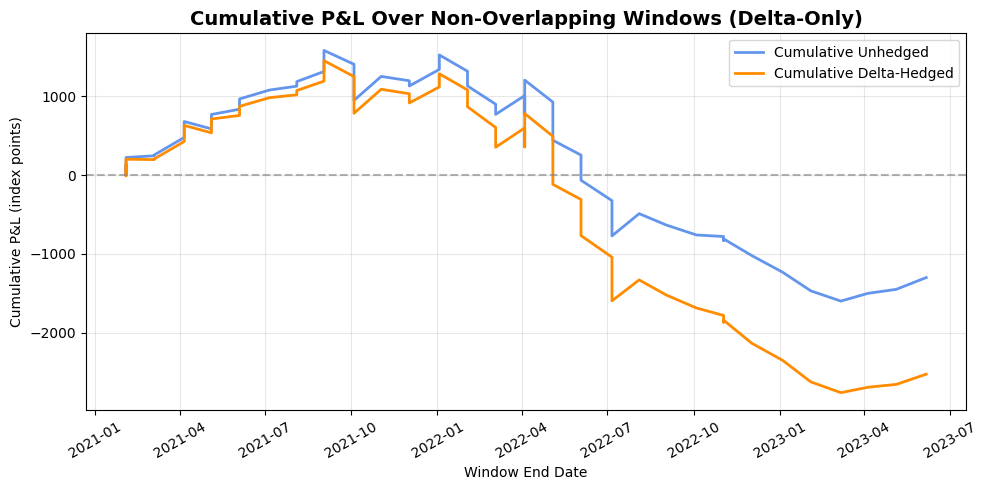

In [11]:
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged']   = res['pnl_hedged'].cumsum()

plt.figure(figsize=(10,5))
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged', color='cornflowerblue', linewidth=2)
plt.plot(res['end'], res['cum_hedged'], label='Cumulative Delta-Hedged', color='darkorange', linewidth=2)
plt.axhline(0, linestyle='--', color='gray', alpha=0.6)
plt.title('Cumulative P&L Over Non‑Overlapping Windows (Delta‑Only)', fontsize=14, fontweight='bold')
plt.xlabel('Window End Date')
plt.ylabel('Cumulative P&L (index points)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

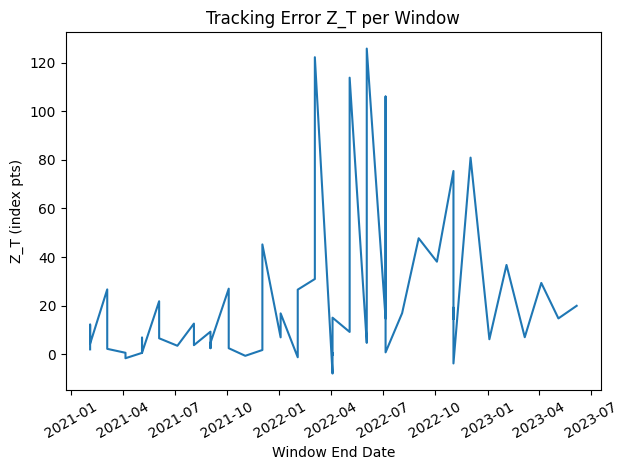

In [12]:
plt.figure()
plt.plot(res['end'], res['tracking_error'])
plt.title('Tracking Error Z_T per Window'); plt.xlabel('Window End Date'); plt.ylabel('Z_T (index pts)')
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

<Figure size 1000x500 with 0 Axes>

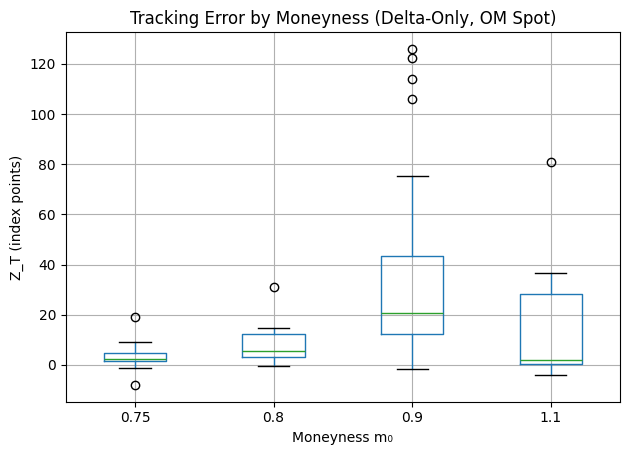

In [13]:
# === 8) Boxplot for tracking error ===
plt.figure(figsize=(10,5))
results_delta.boxplot(column='tracking_error',by='m0')
plt.title('Tracking Error by Moneyness (Delta‑Only, OM Spot)')
plt.suptitle(''); plt.xlabel('Moneyness m₀'); plt.ylabel('Z_T (index points)')
plt.tight_layout(); plt.show()

In [14]:
summary_df = res.groupby('m0')['tracking_error'].agg(
    mean='mean',
    median='median',
    std='std',
    VaR_5pct=lambda x: x.quantile(0.05),
    VaR_1pct=lambda x: x.quantile(0.01)
).round(3)

print("Tracking Error Summary (Delta‑Only Hedging)")
display(summary_df)

Tracking Error Summary (Delta‑Only Hedging)


,mean,median,std,VaR_5pct,VaR_1pct
m0,,,,,
0.75,3.639,2.441,6.195,-3.988,-7.203
0.80,8.062,5.650,8.068,0.273,-0.229
0.90,36.179,20.837,38.928,1.004,-1.450
1.10,19.715,1.988,33.464,-2.770,-3.634


In [15]:
# save to csv
results_delta.to_csv('results_delta.csv', index=False)
print("Delta results saved to results_delta.csv")

Delta results saved to results_delta.csv
